<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

# Цель исследования
1. Обучить модель, которая классифицирует комментарии на позитивные и негативные. 

# Ход исследования
Нам предоставлен набор данных с разметкой о токсичности правок. Данные находятся в датафрейме, который мы получим из файла 'toxic_comments.csv'. О качестве данных нам ничего не известно, поэтому перед тем, как приступать к целям исследования, понадобится обзор данных. Мы проверим данные на ошибки. Затем, на этапе предобработки мы будем искать возможность исправить все ошибки в данных, которые не приведут к искажению конечного результата. Далее приступим к целям исследования.<br>


Таким образом, исследование пройдёт в двенадцать этапов:<br>

* Обзор данных 
* Предобработка данных 
* Анализ данных
* Лемматизация данных
* Отсистка текста
* Подготовка выборок
* Вычисление TF-IDF
* Обучение разных моделей с различными гиперпараметрами
* Выявление лучшей модели 
* Проверка наилучшей модели на тестовой выборке 
* Написание промежуточных выводов 
* Написание общего вывода

## 1. Подготовка

In [1]:
#Импортируем необходимые библиотеки
import pandas as pd
import lightgbm as lgb
import re 
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


import nltk
from nltk import pos_tag
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
from pymystem3 import Mystem

from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mary\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Mary\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mary\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mary\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Загружаем и изучаем датафрейм
try:
    data = pd.read_csv('toxic_comments.csv')
except:    
    pass

In [3]:
#Ознакамливаемся с датафреймом
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
#Проверяем количество пропусков в %
pd.DataFrame(round(data.isna().mean()*100)).style.background_gradient('coolwarm')

,0
Unnamed: 0,0.000000
text,0.000000
toxic,0.000000


Пропусков не обнаружено

In [6]:
#Проверяем количество явных дубликатов
data.duplicated().sum()

0

In [7]:
#Удалим столбец "Unnamed: 0", так как он не несет информативной важности
data = data.drop(['Unnamed: 0'], axis=1)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [9]:
data.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [11]:
#Напишем функцию лемматизации
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,              
                "N": wordnet.NOUN,              
                "V": wordnet.VERB,              
                "R": wordnet.ADV                
               }  
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    return ' '.join(text)

In [ ]:
%%time

data['text'] = data['text'].apply(lemmatize)

In [ ]:
data['text'].head(10)

In [15]:
#Напишем функцию, которая оставит в тексте только кириллические символы и пробелы
def clear_text(text):
    lemm_re = re.sub(r"[^a-zA-Z ']", ' ', text)     
    lemm_tex = ' '.join(lemm_re.split())
    return lemm_tex

data['text'] = data['text'].apply(clear_text)

In [16]:
data.head()

,text,toxic
0,Explanation Why the edits make under my userna...,0
1,D'aww He match this background colour I 'm see...,0
2,Hey man I 'm really not try to edit war It 's ...,0
3,More I ca n't make any real suggestion on impr...,0
4,You sir be my hero Any chance you remember wha...,0


### Вывод:
* Мы загрузили и ознакомились с представленным датафреймом:
    * Всего в датафрейме 3 столбца и 159 291 записи
    * Удалили столбец "Unnamed: 0", так как он не несет информативной важности
* Лемматризировали данные, а так же отчистили текст

## 2. Разделим данные на выборки и вычислим TF-IDF

In [17]:
#Объявим две переменные
features = data.drop(['toxic'], axis=1)
target = data['toxic']

In [18]:
#Разбиваем исходные данные на три выборки, в соотношении 80:10:10 (8:1:1)
#Обучающая выборка
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345, stratify=target)

#Проверяем размер выборки
print('Размер обучающей выборки:')
print(features_train.shape)
print(target_train.shape)

Размер обучающей выборки:
(127433, 1)
(127433,)


In [19]:
#Валидационная и тестовая выборки
features_valid, features_test, target_valid, target_test = train_test_split(
    features_test, target_test, test_size=0.5, random_state=12345, stratify=target_test)

#Проверяем размер выборок
print('Размер валидационной выборки:')
print(features_valid.shape)
print(target_valid.shape)

print()

print('Размер тестовой выборки:')
print(features_test.shape)
print(target_test.shape)

Размер валидационной выборки:
(15929, 1)
(15929,)

Размер тестовой выборки:
(15930, 1)
(15930,)


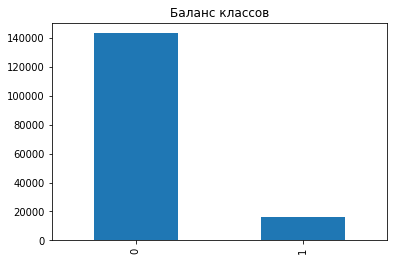

In [21]:
#Проверяем датасет на сбалансированность классов
data['toxic'].value_counts().plot.bar()
plt.title('Баланс классов');

Дисбаланс классов присутствует. Классы несбалансированны, когда их соотношение далеко от 1:1.
Значит в моделях применим технику взвешивания классов.

In [22]:
#Вычислим TF-IDF для тренировочной выборки 
count_tf_idf_train = TfidfVectorizer(stop_words=stopwords)
tf_idf_train = count_tf_idf_train.fit_transform(features_train.text)

print('Размер матрицы:', tf_idf_train.shape)

Размер матрицы: (127433, 141070)


In [23]:
#Вычислим TF-IDF для тестовой выборки 
count_tf_idf_test = TfidfVectorizer(stop_words=stopwords)
tf_idf_test = count_tf_idf_train.transform(features_test.text)

print('Размер матрицы:', tf_idf_test.shape)

Размер матрицы: (15930, 141070)


In [24]:
#Вычислим TF-IDF для валидационной выборки 
count_tf_idf_test = TfidfVectorizer(stop_words=stopwords)
tf_idf_valid = count_tf_idf_train.transform(features_valid.text)

print('Размер матрицы:', tf_idf_test.shape)

Размер матрицы: (15930, 141070)


### Вывод:
* Мы разделили даннные на обучающую, тестовую и валидационную выборки в соотношении 8:1:1
* Вычислили TF-IDF

## 3. Обучение

**Модель Логистической регрессии - LogisticRegression**

In [37]:
%%time
#Исследуем качество логистической регрессии на валидационной выборке и взвесим классы
model_lg = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000, C=14.0, class_weight='balanced')
model_lg.fit(tf_idf_train, target_train) 
predicted_valid = model_lg.predict(tf_idf_valid)
f1_valid_lg = f1_score(target_valid, predicted_valid)

print('F1 наилучшей модели: {:.2f}'.format(f1_valid_lg)) 

F1 наилучшей модели: 0.77
Wall time: 2.01 s


In [38]:
#Измерим AUC-ROC для модели логистической регрессии
probabilities_valid = model_lg.predict_proba(tf_idf_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_valid[:, 1])

print('AUC-ROC лучшей модели логистической регрессии: {:.2f}'.format(auc_roc))

AUC-ROC лучшей модели логистической регрессии: 0.96


**Вывод:** <br>
F1 наиулучшей модели логистической регрессии составляет 0.77 при значении AUC-ROC: 0.96. Значение AUC-ROC отличное. 

**Модель Случайного леса - RandomForestClassifier**

In [60]:
%%time
#Исследуем качество случайного леса на валидационной выборке и взвесим классы
best_model_rf = None
best_result_rf = 0
best_est_rf = 0
best_depth_rf = 0
for est in range(1, 11):
    for depth in range(1, 11):
        model_rf = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
        model_rf.fit(tf_idf_train, target_train)
        predicted_valid = model_rf.predict(tf_idf_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result_rf:
            best_model_rf = model_rf
            best_result_rf = result
            best_est_rf = est
            best_depth_rf = depth
            
print('F1 наилучшей модели: {:.2f}'.format(best_result_rf))
print('Количество деревьев:', best_est_rf)
print('Максимальная глубина:', depth)

F1 наилучшей модели: 0.43
Количество деревьев: 7
Максимальная глубина: 10
Wall time: 29.3 s


In [61]:
#Измерим AUC-ROC для модели случайного леса
probabilities_valid = model_rf.predict_proba(tf_idf_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_valid[:, 1])

print('AUC-ROC лучшей модели случайного леса: {:.2f}'.format(auc_roc))

AUC-ROC лучшей модели случайного леса: 0.78


**Вывод:** <br>
F1 наиулучшей модели случайного леса составляет 0.43 при значении AUC-ROC: 0.78. Значение AUC-ROC хорошее. 

**Модель бустинга - LightGBMClassifier**

In [39]:
%%time
model_lgbmr = LGBMClassifier(class_weight='balanced') 
model_lgbmr.fit(tf_idf_train, target_train)
predict_lgbmr = model_lgbmr.predict(tf_idf_valid)
f1_score_lgbmr = f1_score(target_valid, predict_lgbmr)

print('F1 наилучшей модели бустинга - LightGBMRegressor на валидационной выборке: {:.2f}'.format(f1_score_lgbmr))

F1 наилучшей модели бустинга - LightGBMRegressor на валидационной выборке: 0.74
Wall time: 11.6 s


**Вывод:** <br>
F1 наиулучшей модели бустинга - LightGBMClassifier составляет 0.74. 

### Вывод:
* Было проведено обучение различных моделей:
    * Наилучшей моделью оказалась модель логистической регрессии, F1 наиулучшей модели составляет 0.77 при значении AUC-ROC: 0.96, значение AUC-ROC отличное. 

## 4. Тестирование

In [40]:
%%time
#Исследуем качество логистической регрессии на тестовой выборке и взвесим классы
model_lg_test = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000, C=14.0, class_weight='balanced')
model_lg_test.fit(tf_idf_train, target_train) 
predicted_test = model_lg_test.predict(tf_idf_test)
f1_test_lg = f1_score(target_test, predicted_test)

print('F1 наилучшей модели: {:.2f}'.format(f1_test_lg))

F1 наилучшей модели: 0.76
Wall time: 2.03 s


In [41]:
#Измерим AUC-ROC для модели логистической регрессии
probabilities_test = model_lg_test.predict_proba(tf_idf_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_test[:, 1])

print('AUC-ROC лучшей модели логистической регрессии: {:.2f}'.format(auc_roc))

AUC-ROC лучшей модели логистической регрессии: 0.97


### Вывод:
* Проведено тестирование наилучшей модели - модели логистической регрессии:
    * F1 наиулучшей модели на тестовой выборке составляет 0.76 при значении AUC-ROC: 0.97, значение AUC-ROC отличное. 

## 5. Выводы

1. Мы загрузили и ознакомились с представленным датафреймом
2. Лемматризировали данные, а так же отчистили текст
3. Мы разделили даннные на обучающую, тестовую и валидационную выборки в соотношении 8:1:1
4. Вычислили TF-IDF
5. Провели обучение различных моделей:
    * Наилучшей моделью оказалась модель логистической регрессии, F1 наиулучшей модели составляет 0.77 при значении AUC-ROC: 0.96, значение AUC-ROC отличное. 
    
7. Проведено тестирование наилучшей модели - модели логистической регрессии:
    * F1 наиулучшей модели на тестовой выборке составляет 0.76 при значении AUC-ROC: 0.97, значение AUC-ROC отличное.
    
8. Добились значения метрики F1 не меньше 0.75<br>
<br>
Рекомендации: <br>
С помощью нашей модели, которая умеет качественно и быстро классифицировать комментарии на позитивные и негативные, интернет-магазин «Викишоп» может причлечь еще больше польхователей, за счет быстрой и качественной работы модели.